<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/quantum_ionq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### *IonQ with Cirq*

In [ ]:
!pip install cirq-ionq -q

In [ ]:
import cirq_ionq  # https://docs.ionq.com/sdks/cirq
import cirq       # https://quantumai.google/cirq/hardware/ionq/circuits

In [ ]:
import json
import pickle
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import files
from collections import Counter
import matplotlib.pyplot as plt
import cirq_ionq.ionq_exceptions as ionq_exceptions

In [ ]:
# Connect to IonQ Service and Secret Manager for Token
from google.colab import userdata
api_token = userdata.get('ionq-quantum')
service = cirq_ionq.Service(api_key=api_token)

In [ ]:
# Check Available Backends (Simulators and QPUs) - https://cloud.ionq.com/backends/qpus
headers = {"Authorization": f"apiKey {'ionq-quantum'}"}
r = requests.get("https://api.ionq.co/v0.3/backends", headers=headers)
if r.status_code == 200:
    for i, b in enumerate(r.json(), 1):
        qt = b.get('average_queue_time', 0)
        print(f"\n{i}. {b['backend'].upper()}\n └── Type: {'QPU' if 'qpu' in b['backend'] else 'Simulator'}\n └── Status: {b['status'].upper()}\n └── Qubits: {b['qubits']}\n └── Average Queue Time: {f'{qt/3600:.1f} hours' if qt > 3600 else f'{qt/60:.1f} minutes' if qt > 60 else f'{qt} seconds'}" + (''.join([f"\n └── Available Noise Models: {', '.join(b['noise_models'])}" if 'noise_models' in b else "", f"\n └── Characterization: Available" if 'characterization_url' in b else "", f"\n └── DEGRADED SERVICE" if b.get('degraded', False) else ""])))
else: print(f"Backend check failed: {r.status_code}\nError details: {r.text}")


1. QPU.HARMONY
 └── Type: QPU
 └── Status: RETIRED
 └── Qubits: 11
 └── Average Queue Time: 0 seconds

2. QPU.ARIA-1
 └── Type: QPU
 └── Status: UNAVAILABLE
 └── Qubits: 25
 └── Average Queue Time: 3954.8 hours
 └── Characterization: Available

3. QPU.ARIA-2
 └── Type: QPU
 └── Status: UNAVAILABLE
 └── Qubits: 25
 └── Average Queue Time: 54887.5 hours
 └── Characterization: Available

4. QPU.FORTE-1
 └── Type: QPU
 └── Status: UNAVAILABLE
 └── Qubits: 36
 └── Average Queue Time: 3461.2 hours
 └── Characterization: Available

5. QPU.FORTE-ENTERPRISE-1
 └── Type: QPU
 └── Status: AVAILABLE
 └── Qubits: 36
 └── Average Queue Time: 38475.3 hours
 └── Characterization: Available

6. QPU.FORTE-ENTERPRISE-2
 └── Type: QPU
 └── Status: UNAVAILABLE
 └── Qubits: 36
 └── Average Queue Time: 0 seconds

7. SIMULATOR
 └── Type: Simulator
 └── Status: AVAILABLE
 └── Qubits: 29
 └── Average Queue Time: 0 seconds
 └── Available Noise Models: aria-1, harmony, ideal


In [ ]:
# Calibration Data - https://quantumai.google/cirq/hardware/ionq/calibrationsx
service.get_current_calibration()
print(calibration.fidelities())
print(calibration.timings())
print(calibration.num_qubits())

In [ ]:
# Define Circuit - Two-Qubit Bell state Preparation |Φ+⟩
q0, q1 = cirq.LineQubit.range(2)
circuit = cirq.Circuit(
    cirq.H(q0),
    cirq.CNOT(q0, q1),
    cirq.measure(q0, q1, key='x'))
print(circuit)

0: ───H───@───M('x')───
          │   │
1: ───────X───M────────


*Hadamard on $q_0$:*  $|00\rangle \xrightarrow{H \otimes I} \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes |0\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |10\rangle)$

*CNOT (controlled by $q_0$) on $q_1$:* CNOT flips $q_1$ only if $q_0$ is $|1\rangle$  $\frac{1}{\sqrt{2}}(|00\rangle + |10\rangle) \xrightarrow{\text{CNOT}} \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) = |\Phi^+\rangle$

This final state, $|\Phi^+\rangle$, is an *entangled Bell state*:
* The amplitude for $|00\rangle$ is $1/\sqrt{2}$. The probability $P('00') = |1/\sqrt{2}|^2 = 0.5$
* The amplitude for $|11\rangle$ is $1/\sqrt{2}$. The probability $P('11') = |1/\sqrt{2}|^2 = 0.5$

In [ ]:
# Theoretical Calculation (Exact probability distribution based on state vector simulation)
def calculate_exact_noiseless_probabilities(circuit: cirq.Circuit) -> dict:
    circuit_without_measurements = cirq.drop_terminal_measurements(circuit)
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit_without_measurements)
    final_state_vector = result.final_state_vector
    exact_counts = {}
    for i, amplitude in enumerate(final_state_vector):
        probability = np.abs(amplitude)**2
        count = round(probability * 100)  # Convert to counts for number of shots ('repetitions=')
        if count > 0:
            exact_counts[i] = count  # Use integer key like {0: 50, 3: 50}
    return exact_counts
theoretical_prediction = calculate_exact_noiseless_probabilities(circuit)
print("--- Theoretical Count Distribution ---")
print(f"Counter({theoretical_prediction})")
theoretical_counter = Counter(theoretical_prediction) # mock counter object to match format
with open('theoretical_result.pkl', 'wb') as f:
    pickle.dump(theoretical_counter, f)

--- Theoretical Count Distribution ---
Counter({0: 50, 3: 50})


In [ ]:
# Noiseless simulation
result = service.run(
    circuit=circuit,
    target="simulator",
    repetitions=100,
    name="Noiseless Cirq Simulation")
print(result.histogram(key='x'))
print(result)
with open('noiseless_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({0: 51, 3: 49})
x=1000000001100011111110001001010010011000111111001000111001110110101100100110010100100111010110110001, 1000000001100011111110001001010010011000111111001000111001110110101100100110010100100111010110110001


In [ ]:
# Noisy simulation
result = service.run(
    circuit=circuit,
    target="simulator",
    repetitions=100,
    name="Noisy Cirq Simulation",
    extra_query_params={"noise": {"model": "forte-enterprise-1"}})
print(result.histogram(key='x'))
print(result)
with open('noisy_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({0: 54, 3: 45, 1: 1})
x=0110110000100101000001010000100000101101010110010111010110000011010011100101100011010111111000010101, 0110110000101101000001010000100000101101010110010111010110000011010011100101100011010111111000010101


In [ ]:
# Quantum Simulation
# (https://docs.ionq.com/guides/qpu-submission-checklist)
job = service.create_job(
    circuit=circuit,
    target="qpu.forte-enterprise-1", # forte-enterprise-1, aria-1
    repetitions=100,
    name="QPU Cirq Simulation")
print(job.job_id())   # https://cloud.ionq.com/jobs

019991ee-9f11-7227-a2de-5522b789b561


In [ ]:
print(job.status())

submitted


In [ ]:
print(job.status())

completed


In [ ]:
# Retrieve a job
job_id = "019991ee-9f11-7227-a2de-5522b789b561"
job = service.get_job(job_id)

# Get the first result from the list
results_list = job.results()
result = results_list[0].to_cirq_result()  # Access first element
print(result.histogram(key='x'))
# Save results into file
with open('quantum_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({3: 56, 0: 44})


Results loaded successfully!


COMPARISON TABLE:
State Binary  Theoretical Count Theoretical Prob  Noiseless Count Noiseless Prob  Noisy Count Noisy Prob  Quantum Count Quantum Prob  Quantum vs Theoretical  Quantum vs Noiseless  Quantum vs Noisy
 |00>     00                 50            0.500               51          0.510           54      0.540             44        0.440                      -6                    -7               -10
 |01>     01                  0            0.000                0          0.000            1      0.010              0        0.000                       0                     0                -1
 |11>     11                 50            0.500               49          0.490           45      0.450             56        0.560                       6                     7                11
SUMMARY STATISTICS:
Noiseless Fidelity            : 1.000
Noisy Fidelity                : 0.990
Quantum Fidelity              : 1.000
Noiseless Error Rate         

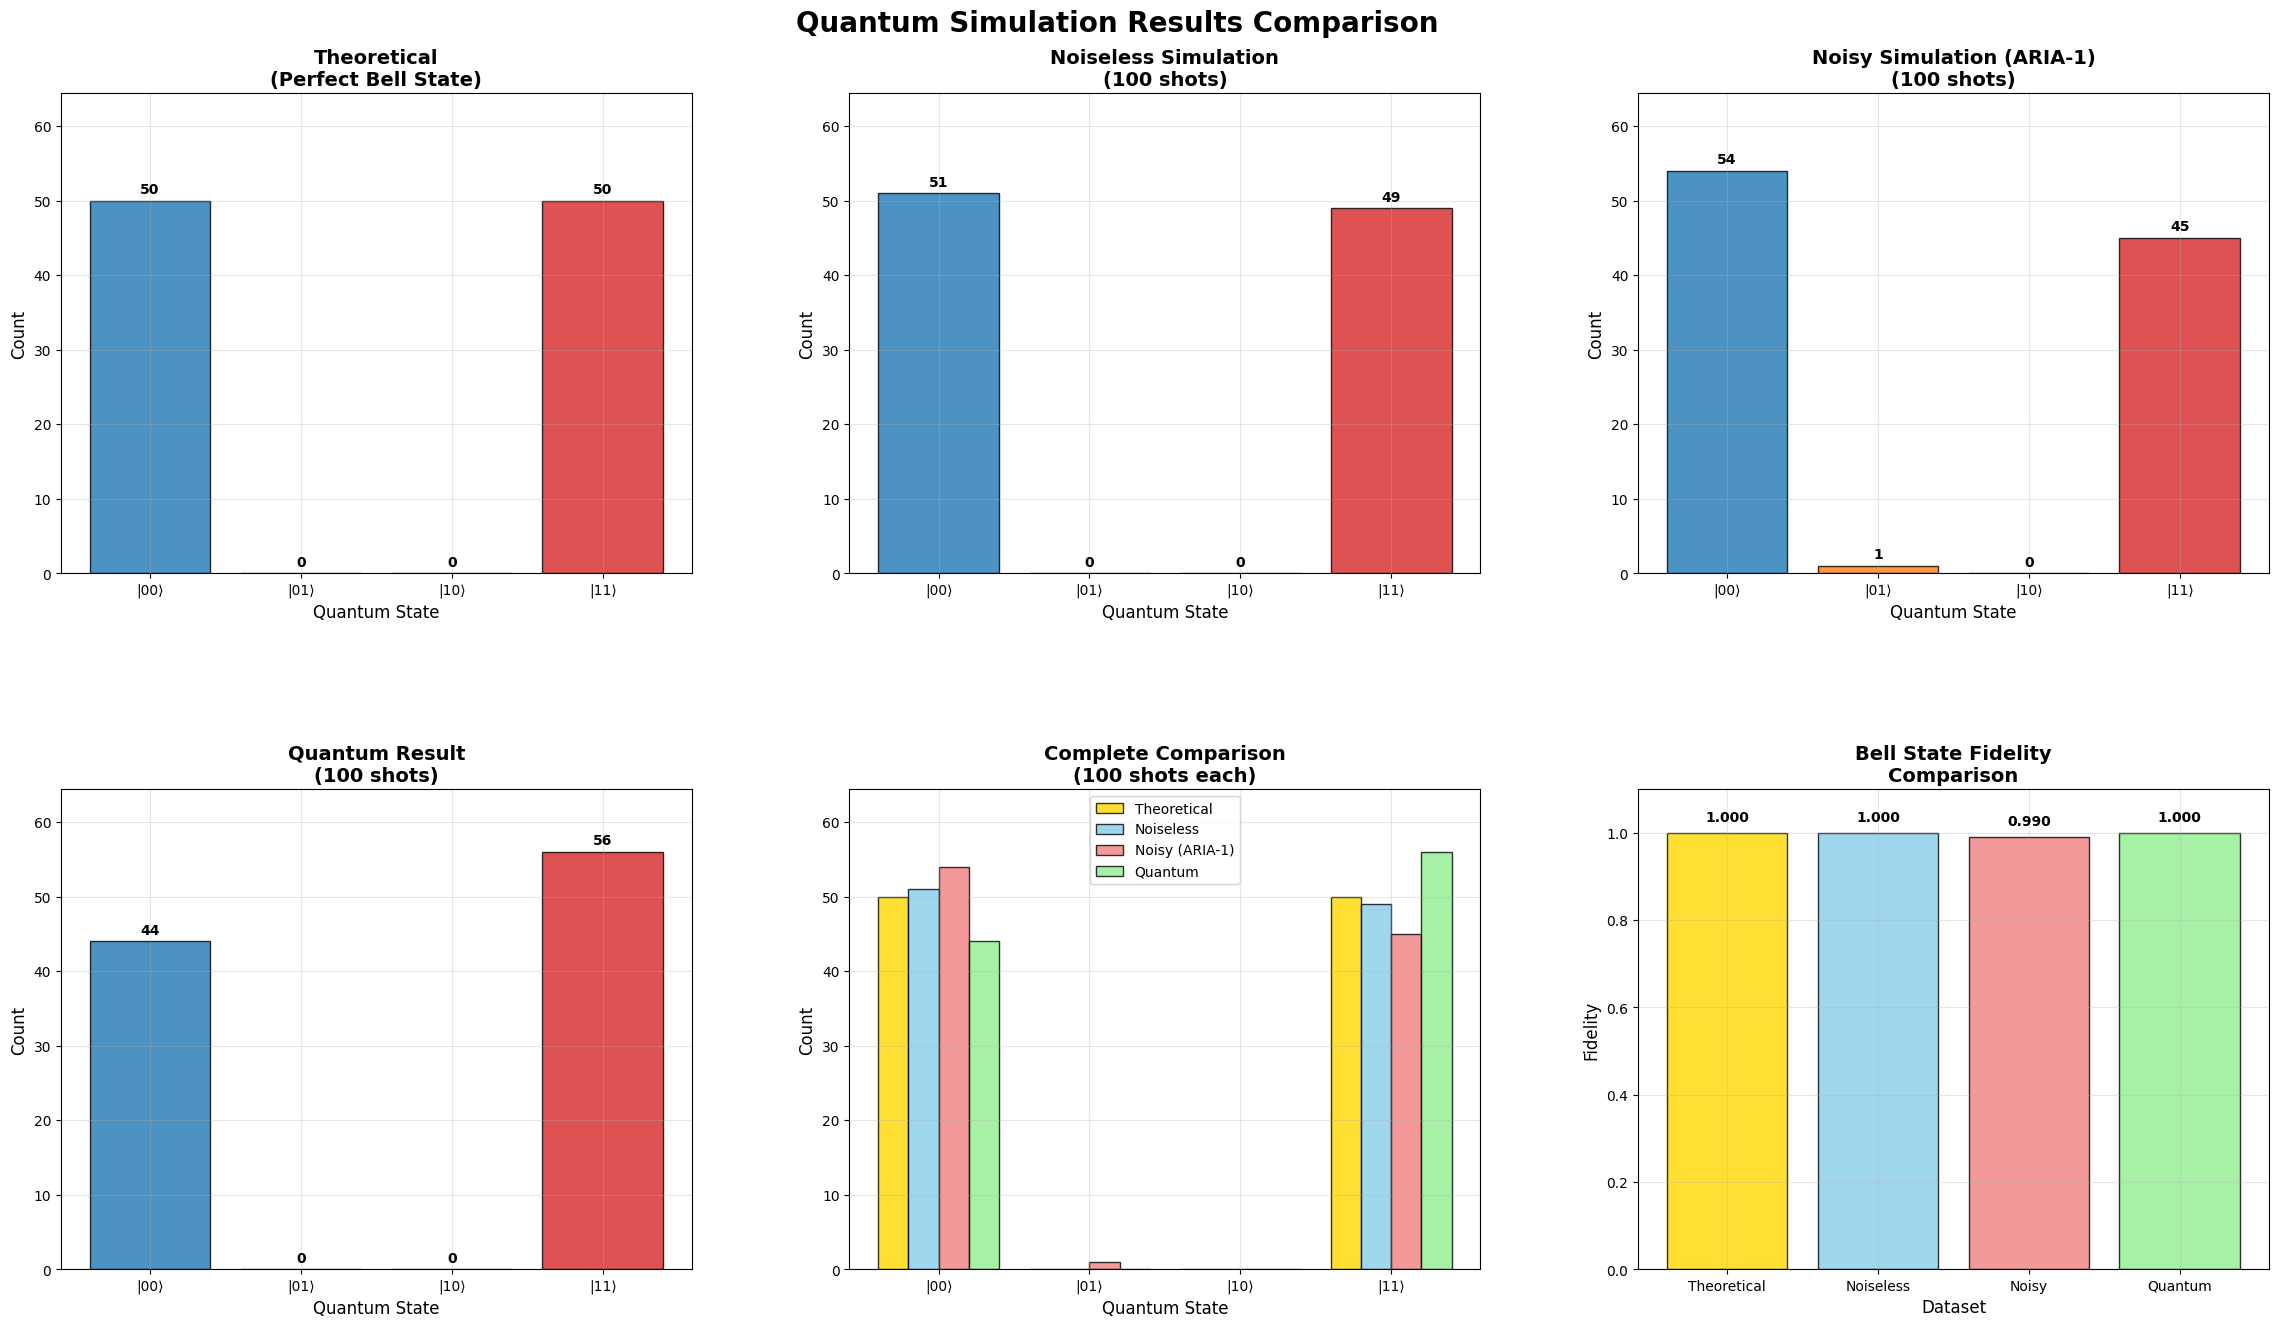

RAW RESULTS:
Theoretical histogram: {0: 50, 3: 50}
Noiseless histogram: {3: 49, 0: 51}
Noisy histogram: {0: 54, 3: 45, 1: 1}
Quantum histogram: {0: 44, 3: 56}

HELLINGER DISTANCES:
(0 = identical distributions, 1 = maximally different)
Theoretical  vs Noiseless   : 0.0071
Theoretical  vs Noisy       : 0.0777
Theoretical  vs Quantum     : 0.0425
Noiseless    vs Theoretical : 0.0071
Noiseless    vs Noisy       : 0.0751
Noiseless    vs Quantum     : 0.0496
Noisy        vs Theoretical : 0.0777
Noisy        vs Noiseless   : 0.0751
Noisy        vs Quantum     : 0.1028
Quantum      vs Theoretical : 0.0425
Quantum      vs Noiseless   : 0.0496
Quantum      vs Noisy       : 0.1028

Distance Matrix:
             Theoretical  Noiseless   Noisy  Quantum
Theoretical       0.0000     0.0071  0.0777   0.0425
Noiseless         0.0071     0.0000  0.0751   0.0496
Noisy             0.0777     0.0751  0.0000   0.1028
Quantum           0.0425     0.0496  0.1028   0.0000

Closest to theoretical: Noiseless (d

In [ ]:
# @title Comparison of Results
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import pickle

# Load the saved results from local Colab environment
with open('noiseless_result.pkl', 'rb') as f:
    noiseless_result = pickle.load(f)

with open('noisy_result.pkl', 'rb') as f:
    noisy_result = pickle.load(f)

with open('theoretical_result.pkl', 'rb') as f:
    theoretical_data = pickle.load(f)

# Load the new quantum result
with open('quantum_result.pkl', 'rb') as f:
    quantum_result = pickle.load(f)

# Extract histogram data
noiseless_hist = noiseless_result.histogram(key='x')
noisy_hist = noisy_result.histogram(key='x')
theoretical_hist = theoretical_data  # Already in the right format (Counter)

# Extract quantum histogram (assuming similar structure to others)
if hasattr(quantum_result, 'histogram'):
    quantum_hist = quantum_result.histogram(key='x')
else:
    # If it's already a histogram/counter
    quantum_hist = quantum_result

print("Results loaded successfully!")
print("\n" + "="*50 + "\n")

# Create comparison table with 4 datasets
def create_comparison_table(theoretical_hist, noiseless_hist, noisy_hist, quantum_hist):
    """Create a comprehensive comparison table for 4 datasets"""

    # Get all possible states (0, 1, 2, 3 for 2-qubit system)
    all_states = set(list(theoretical_hist.keys()) + list(noiseless_hist.keys()) +
                    list(noisy_hist.keys()) + list(quantum_hist.keys()))

    # Create table data
    table_data = []
    for state in sorted(all_states):
        theoretical_count = theoretical_hist.get(state, 0)
        noiseless_count = noiseless_hist.get(state, 0)
        noisy_count = noisy_hist.get(state, 0)
        quantum_count = quantum_hist.get(state, 0)

        # Calculate probabilities (assuming 100 repetitions for each)
        theoretical_prob = theoretical_count / 100
        noiseless_prob = noiseless_count / 100
        noisy_prob = noisy_count / 100
        quantum_prob = quantum_count / 100

        # Convert state to binary representation
        binary_state = format(state, '02b')

        table_data.append({
            'State': f'|{binary_state}>',
            'Binary': binary_state,
            'Theoretical Count': theoretical_count,
            'Theoretical Prob': f'{theoretical_prob:.3f}',
            'Noiseless Count': noiseless_count,
            'Noiseless Prob': f'{noiseless_prob:.3f}',
            'Noisy Count': noisy_count,
            'Noisy Prob': f'{noisy_prob:.3f}',
            'Quantum Count': quantum_count,
            'Quantum Prob': f'{quantum_prob:.3f}',
            'Quantum vs Theoretical': quantum_count - theoretical_count,
            'Quantum vs Noiseless': quantum_count - noiseless_count,
            'Quantum vs Noisy': quantum_count - noisy_count
        })

    return pd.DataFrame(table_data)

# Create and display comparison table
comparison_df = create_comparison_table(theoretical_hist, noiseless_hist, noisy_hist, quantum_hist)
print("COMPARISON TABLE:")
print("="*120)
print(comparison_df.to_string(index=False))

# Calculate summary statistics for all datasets
def calculate_summary_stats(noiseless_hist, noisy_hist, quantum_hist):
    """Calculate summary statistics for comparison of all datasets"""

    # Expected outcomes for Bell state: |00> and |11> should be equally likely
    expected_states = [0, 3]  # |00> = 0, |11> = 3 in binary

    noiseless_ideal = sum(noiseless_hist.get(state, 0) for state in expected_states)
    noisy_ideal = sum(noisy_hist.get(state, 0) for state in expected_states)
    quantum_ideal = sum(quantum_hist.get(state, 0) for state in expected_states)

    noiseless_error = sum(noiseless_hist.get(state, 0) for state in [1, 2])  # |01> and |10>
    noisy_error = sum(noisy_hist.get(state, 0) for state in [1, 2])
    quantum_error = sum(quantum_hist.get(state, 0) for state in [1, 2])

    stats = {
        'Noiseless Fidelity': noiseless_ideal / 100,
        'Noisy Fidelity': noisy_ideal / 100,
        'Quantum Fidelity': quantum_ideal / 100,
        'Noiseless Error Rate': noiseless_error / 100,
        'Noisy Error Rate': noisy_error / 100,
        'Quantum Error Rate': quantum_error / 100,
        'Quantum vs Noiseless Fidelity': (quantum_ideal - noiseless_ideal) / 100,
        'Quantum vs Noisy Fidelity': (quantum_ideal - noisy_ideal) / 100,
        'Quantum vs Noiseless Error': (quantum_error - noiseless_error) / 100,
        'Quantum vs Noisy Error': (quantum_error - noisy_error) / 100
    }

    return stats

# Calculate and display summary statistics
summary_stats = calculate_summary_stats(noiseless_hist, noisy_hist, quantum_hist)
print("SUMMARY STATISTICS:")
print("="*50)
for key, value in summary_stats.items():
    print(f"{key:30}: {value:.3f}")

# Create comprehensive histogram visualization
def plot_comparison_histograms(theoretical_hist, noiseless_hist, noisy_hist, quantum_hist):
    """Create comprehensive histogram comparison with 5 subplots"""
    fig, axes = plt.subplots(2, 3, figsize=(24, 14))
    fig.suptitle('Quantum Simulation Results Comparison', fontsize=20, fontweight='bold', y=0.98)

    # Flatten axes for easier indexing
    ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

    # Prepare data for plotting
    states = [0, 1, 2, 3]  # All possible 2-qubit states
    state_labels = ['|00⟩', '|01⟩', '|10⟩', '|11⟩']

    theoretical_counts = [theoretical_hist.get(state, 0) for state in states]
    noiseless_counts = [noiseless_hist.get(state, 0) for state in states]
    noisy_counts = [noisy_hist.get(state, 0) for state in states]
    quantum_counts = [quantum_hist.get(state, 0) for state in states]

    # Colors for each state
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    max_count = max(max(theoretical_counts), max(noiseless_counts),
                   max(noisy_counts), max(quantum_counts))

    def add_count_labels(ax, bars, counts):
        """Helper function to add count labels on bars"""
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + max_count*0.01,
                   f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    # Plot 1: Theoretical
    bars1 = ax1.bar(state_labels, theoretical_counts, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Theoretical\n(Perfect Bell State)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_xlabel('Quantum State', fontsize=12)
    ax1.set_ylim(0, max_count * 1.15)
    ax1.grid(True, alpha=0.3)
    add_count_labels(ax1, bars1, theoretical_counts)

    # Plot 2: Noiseless simulation
    bars2 = ax2.bar(state_labels, noiseless_counts, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('Noiseless Simulation\n(100 shots)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_xlabel('Quantum State', fontsize=12)
    ax2.set_ylim(0, max_count * 1.15)
    ax2.grid(True, alpha=0.3)
    add_count_labels(ax2, bars2, noiseless_counts)

    # Plot 3: Noisy simulation
    bars3 = ax3.bar(state_labels, noisy_counts, color=colors, alpha=0.8, edgecolor='black')
    ax3.set_title('Noisy Simulation (ARIA-1)\n(100 shots)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Count', fontsize=12)
    ax3.set_xlabel('Quantum State', fontsize=12)
    ax3.set_ylim(0, max_count * 1.15)
    ax3.grid(True, alpha=0.3)
    add_count_labels(ax3, bars3, noisy_counts)

    # Plot 4: Quantum result
    bars4 = ax4.bar(state_labels, quantum_counts, color=colors, alpha=0.8, edgecolor='black')
    ax4.set_title('Quantum Result\n(100 shots)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Count', fontsize=12)
    ax4.set_xlabel('Quantum State', fontsize=12)
    ax4.set_ylim(0, max_count * 1.15)
    ax4.grid(True, alpha=0.3)
    add_count_labels(ax4, bars4, quantum_counts)

    # Plot 5: All comparisons
    x = np.arange(len(state_labels))
    width = 0.2

    bars5_1 = ax5.bar(x - 1.5*width, theoretical_counts, width, label='Theoretical',
                      color='gold', alpha=0.8, edgecolor='black')
    bars5_2 = ax5.bar(x - 0.5*width, noiseless_counts, width, label='Noiseless',
                      color='skyblue', alpha=0.8, edgecolor='black')
    bars5_3 = ax5.bar(x + 0.5*width, noisy_counts, width, label='Noisy (ARIA-1)',
                      color='lightcoral', alpha=0.8, edgecolor='black')
    bars5_4 = ax5.bar(x + 1.5*width, quantum_counts, width, label='Quantum',
                      color='lightgreen', alpha=0.8, edgecolor='black')

    ax5.set_title('Complete Comparison\n(100 shots each)', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Count', fontsize=12)
    ax5.set_xlabel('Quantum State', fontsize=12)
    ax5.set_xticks(x)
    ax5.set_xticklabels(state_labels)
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3)
    ax5.set_ylim(0, max_count * 1.15)

    # Plot 6: Fidelity comparison
    datasets = ['Theoretical', 'Noiseless', 'Noisy', 'Quantum']
    fidelities = [
        sum(theoretical_counts[i] for i in [0, 3]) / 100,
        sum(noiseless_counts[i] for i in [0, 3]) / 100,
        sum(noisy_counts[i] for i in [0, 3]) / 100,
        sum(quantum_counts[i] for i in [0, 3]) / 100
    ]

    bars6 = ax6.bar(datasets, fidelities, color=['gold', 'skyblue', 'lightcoral', 'lightgreen'],
                   alpha=0.8, edgecolor='black')
    ax6.set_title('Bell State Fidelity\nComparison', fontsize=14, fontweight='bold')
    ax6.set_ylabel('Fidelity', fontsize=12)
    ax6.set_xlabel('Dataset', fontsize=12)
    ax6.set_ylim(0, 1.1)
    ax6.grid(True, alpha=0.3)

    # Add fidelity labels
    for bar, fidelity in zip(bars6, fidelities):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{fidelity:.3f}', ha='center', va='bottom', fontweight='bold')

    # Adjust subplot spacing manually
    plt.subplots_adjust(left=0.06, bottom=0.08, right=0.98, top=0.92, wspace=0.25, hspace=0.45)
    plt.show()

# Generate the plots
plot_comparison_histograms(theoretical_hist, noiseless_hist, noisy_hist, quantum_hist)

# Print raw results for reference
print("RAW RESULTS:")
print("="*40)
print("Theoretical histogram:", dict(theoretical_hist))
print("Noiseless histogram:", dict(noiseless_hist))
print("Noisy histogram:", dict(noisy_hist))
print("Quantum histogram:", dict(quantum_hist))

# Enhanced analysis: Hellinger distances between all pairs
def hellinger_distance(p, q):
    """Calculate Hellinger distance between two probability distributions"""
    # Ensure both distributions have the same states
    all_states = set(list(p.keys()) + list(q.keys()))

    p_probs = np.array([p.get(state, 0) / sum(p.values()) for state in sorted(all_states)])
    q_probs = np.array([q.get(state, 0) / sum(q.values()) for state in sorted(all_states)])

    return np.sqrt(0.5 * np.sum((np.sqrt(p_probs) - np.sqrt(q_probs))**2))

# Calculate all pairwise Hellinger distances
print("\nHELLINGER DISTANCES:")
print("="*40)
print("(0 = identical distributions, 1 = maximally different)")

datasets = {
    'Theoretical': theoretical_hist,
    'Noiseless': noiseless_hist,
    'Noisy': noisy_hist,
    'Quantum': quantum_hist
}

distance_matrix = []
for name1, hist1 in datasets.items():
    row = []
    for name2, hist2 in datasets.items():
        if name1 != name2:
            distance = hellinger_distance(hist1, hist2)
            print(f"{name1:12} vs {name2:12}: {distance:.4f}")
            row.append(distance)
        else:
            row.append(0.0)
    distance_matrix.append(row)

# Create distance matrix dataframe
distance_df = pd.DataFrame(distance_matrix,
                          index=list(datasets.keys()),
                          columns=list(datasets.keys()))

print(f"\nDistance Matrix:")
print(distance_df.round(4))

# Additional analysis: Which dataset is closest to theoretical?
theoretical_distances = {}
for name, hist in datasets.items():
    if name != 'Theoretical':
        theoretical_distances[name] = hellinger_distance(theoretical_hist, hist)

closest_to_theoretical = min(theoretical_distances, key=theoretical_distances.get)
print(f"\nClosest to theoretical: {closest_to_theoretical} (distance: {theoretical_distances[closest_to_theoretical]:.4f})")